In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from scipy.io import loadmat
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
%matplotlib inline

import random
seed = 666
random.seed(seed)

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

check ABCD motion

In [3]:
data_dir = Path("/home/yizi/inv-vae/data/abcd")
abcd_motion = pd.read_csv(data_dir/"abcd_motion/abcd_drsip101.txt", sep="\t", low_memory=False)
abcd_motion_desc = abcd_motion.iloc[0]
abcd_motion = abcd_motion.iloc[1:]

In [4]:
abcd_data = loadmat(data_dir/"abcd_5000.mat")
abcd_sub_id = abcd_data["sub_withnet_id"].squeeze()
abcd_sub_id = np.array([abcd_sub_id[i].item()[:4] + "_" + abcd_sub_id[i].item()[4:] for i in range(len(abcd_sub_id))])
abcd_network = abcd_data["count_network"].transpose(2,0,1)
abcd_trans = abcd_data["translation"]
abcd_rotat = abcd_data["rotation"]
abcd_cog = abcd_data["nih_cogn"]
abcd_cog_desc = abcd_data["nih_cogn_colname"].squeeze()

In [5]:
abcd_common_id = np.intersect1d(abcd_sub_id, abcd_motion["subjectkey"])

In [6]:
abcd_eddy_mean = np.array([
    abcd_motion.loc[abcd_motion["subjectkey"] == abcd_common_id[i]]["dmri_rsi_meanmotion"].to_numpy(dtype=np.double)[0] for i in range(len(abcd_common_id))
])

In [7]:
tmp_order = np.array([np.argwhere(abcd_sub_id == abcd_common_id[i]) for i in range(len(abcd_common_id))]).squeeze()

In [8]:
abcd_network = abcd_network[tmp_order]
abcd_trans = abcd_trans[tmp_order]
abcd_rotat = abcd_rotat[tmp_order]
abcd_cog = abcd_cog[tmp_order]

In [9]:
nan_mask = np.isnan(abcd_eddy_mean)

In [10]:
abcd_eddy_mean = abcd_eddy_mean[~nan_mask]
abcd_network = abcd_network[~nan_mask]
abcd_trans = abcd_trans[~nan_mask]
abcd_rotat = abcd_rotat[~nan_mask]
abcd_cog = abcd_cog[~nan_mask]

zero_mask = abcd_trans == 0 # 0 indicates missing frames
abcd_trans[zero_mask] = np.nan
abcd_rotat[zero_mask] = np.nan

In [11]:
abcd_data_dict = {}
abcd_data_dict.update({"network": abcd_network})
abcd_data_dict.update({"eddy_motion": abcd_eddy_mean})
abcd_data_dict.update({"trans": abcd_trans})
abcd_data_dict.update({"rotat": abcd_rotat})
abcd_data_dict.update({"cog": abcd_cog})
# np.save(data_dir/"abcd_data_dict.npy", abcd_data_dict)

In [12]:
print(pearsonr(abcd_eddy_mean, np.nanmean(abcd_trans, 1))[0])
print(pearsonr(abcd_eddy_mean, np.nanmean(abcd_rotat, 1))[0])
print(pearsonr(abcd_eddy_mean, np.nanmedian(abcd_trans, 1))[0])
print(pearsonr(abcd_eddy_mean, np.nanmedian(abcd_rotat, 1))[0])

0.16633363044807803
0.17422690564250362
0.4649273831312972
0.4454727070069074


In [13]:
from sklearn.preprocessing import StandardScaler

def normalize(x):
    return StandardScaler().fit_transform(x[:,None])

from inv_vae.utils.helpers import min_max_standardize

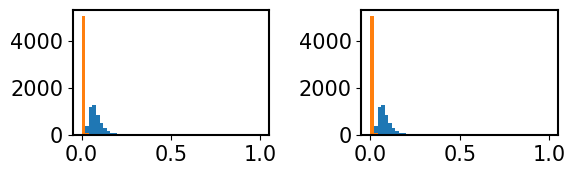

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
ax1.hist(min_max_standardize(abcd_eddy_mean), 50);
ax1.hist(min_max_standardize(np.nanmean(abcd_trans, 1)), 50)
ax2.hist(min_max_standardize(abcd_eddy_mean), 50);
ax2.hist(min_max_standardize(np.nanmean(abcd_rotat, 1)), 50)
plt.tight_layout()

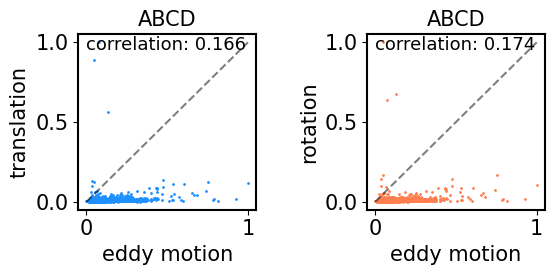

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.scatter(min_max_standardize(abcd_eddy_mean), 
            min_max_standardize(np.nanmean(abcd_trans, 1)), 
            s=1, c="dodgerblue")
ax1.plot([0, 1], [0, 1], ls="--", alpha=.5, c="k")
ax1.set_xlabel("eddy motion")
ax1.set_ylabel("translation")
ax1.set_title("ABCD")
ax1.text(0, 0.95, "correlation: 0.166", fontsize=13)
ax2.scatter(min_max_standardize(abcd_eddy_mean), 
            min_max_standardize(np.nanmean(abcd_rotat, 1)), 
            s=1, c="coral")
ax2.plot([0, 1], [0, 1], ls="--", c="k", alpha=.5)
ax2.set_xlabel("eddy motion")
ax2.set_ylabel("rotation")
ax2.set_title("ABCD")
ax2.text(0, 0.95, "correlation: 0.174", fontsize=13)
plt.tight_layout()
plt.savefig('../saved_figs/abcd_eddy_vs_residual_motion.png', facecolor='white', dpi=800)

check HCP motion

In [5]:
data_dir = Path("/home/yizi/inv-vae/data/hcp")
hcp_data = loadmat(data_dir/"HCP_subcortical_CMData_desikan.mat")

In [6]:
hcp_sub_id = hcp_data["all_id"].squeeze()
hcp_tensor = hcp_data["loaded_tensor_sub"].transpose(3,2,0,1) # preprocess this matrix

In [7]:
hcp_network = []
for i in range(hcp_tensor.shape[0]):
    ith = np.float32(hcp_tensor[i,0,:,:] + np.transpose(hcp_tensor[i,0,:,:]))
    np.fill_diagonal(ith,np.mean(ith, 0))
    ith = ith[18:86, 18:86]
    hcp_network.append(ith)
hcp_network = np.array(hcp_network)

In [8]:
hcp_trans = loadmat(data_dir/"all_motion.mat")["all_motion"]
hcp_rotat = loadmat(data_dir/"all_rotation.mat")["all_rotation"]

In [9]:
hcp_cog = loadmat(data_dir/"HCP_Covariates.mat")["cog_measure"].transpose()
hcp_cog_id = loadmat(data_dir/"HCP_Covariates.mat")["allsubject_id"]

In [10]:
hcp_common_id = np.intersect1d(hcp_sub_id, hcp_cog_id)

In [11]:
hcp_cog_order = np.array([np.argwhere(hcp_cog_id == hcp_common_id[i]) for i in range(len(hcp_common_id))]).squeeze()
hcp_cog = hcp_cog[hcp_cog_order]
hcp_sub_order = np.array([np.argwhere(hcp_sub_id == hcp_common_id[i]) for i in range(len(hcp_common_id))]).squeeze()
hcp_network = hcp_network[hcp_sub_order]
hcp_trans = hcp_trans[hcp_sub_order]
hcp_rotat = hcp_rotat[hcp_sub_order]

In [12]:
zero_mask = hcp_trans == 0 # 0 indicates missing frames
hcp_trans[zero_mask] = np.nan
hcp_rotat[zero_mask] = np.nan

In [30]:
hcp_eddy_mean = []
for sub_id in hcp_common_id:
    eddy_path = data_dir/f"hcp_motion/{sub_id}/T1w/Diffusion/eddylogs/eddy_unwarped_images.eddy_movement_rms"
    hcp_eddy_mean.append(
        pd.read_csv(eddy_path, delim_whitespace=True).to_numpy().mean(0)[0]
    )
hcp_eddy_mean = np.array(hcp_eddy_mean)

In [32]:
hcp_num_outlier = []
for sub_id in hcp_common_id:
    outlier_path = data_dir/f"hcp_motion/{sub_id}/T1w/Diffusion/eddylogs/eddy_unwarped_images.eddy_outlier_report"
    with open(outlier_path, 'r') as f:
        for count, line in enumerate(f):
            pass
    hcp_num_outlier.append(
        count
    )
hcp_num_outlier = np.array(hcp_num_outlier)

In [34]:
nan_mask = np.delete(np.arange(len(hcp_common_id)), [148, 179, 438, 823])
hcp_eddy_mean = hcp_eddy_mean[nan_mask]
hcp_num_outlier = hcp_num_outlier[nan_mask]
hcp_trans = hcp_trans[nan_mask]
hcp_rotat = hcp_rotat[nan_mask]
hcp_network = hcp_network[nan_mask]
hcp_cog = hcp_cog[nan_mask]

In [26]:
hcp_data_dict = {}
hcp_data_dict.update({"network": hcp_network})
hcp_data_dict.update({"eddy_motion": hcp_eddy_mean})
hcp_data_dict.update({"trans": hcp_trans})
hcp_data_dict.update({"rotat": hcp_rotat})
hcp_data_dict.update({"cog": hcp_cog})
# np.save(data_dir/"hcp_data_dict.npy", hcp_data_dict)

In [27]:
print(pearsonr(hcp_eddy_mean, np.nanmean(hcp_trans, 1))[0])
print(pearsonr(hcp_eddy_mean, np.nanmean(hcp_rotat, 1))[0])
print(pearsonr(hcp_eddy_mean, np.nanmedian(hcp_trans, 1))[0])
print(pearsonr(hcp_eddy_mean, np.nanmedian(hcp_rotat, 1))[0])

0.17588835331355646
0.17159950497066975
0.15338530799210046
0.1597247451166659


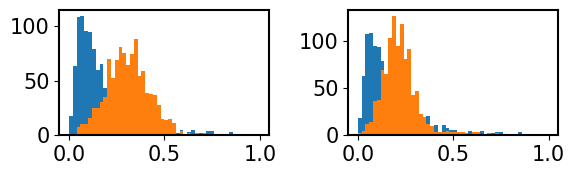

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
ax1.hist(min_max_standardize(hcp_eddy_mean), 50);
ax1.hist(min_max_standardize(np.nanmean(hcp_trans, 1)), 50)
ax2.hist(min_max_standardize(hcp_eddy_mean), 50);
ax2.hist(min_max_standardize(np.nanmean(hcp_rotat, 1)), 50)
plt.tight_layout()

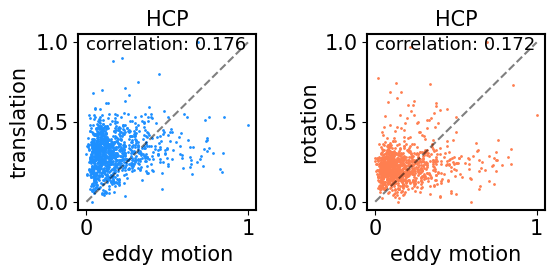

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.scatter(min_max_standardize(hcp_eddy_mean), 
            min_max_standardize(np.nanmean(hcp_trans, 1)), 
            s=1, c="dodgerblue")
ax1.plot([0, 1], [0, 1], ls="--", alpha=.5, c="k")
ax1.set_xlabel("eddy motion")
ax1.set_ylabel("translation")
ax1.set_title("HCP")
ax1.text(0, 0.95, "correlation: 0.176", fontsize=13)
ax2.scatter(min_max_standardize(hcp_eddy_mean), 
            min_max_standardize(np.nanmean(hcp_rotat, 1)), 
            s=1, c="coral")
ax2.plot([0, 1], [0, 1], ls="--", c="k", alpha=.5)
ax2.set_xlabel("eddy motion")
ax2.set_ylabel("rotation")
ax2.set_title("HCP")
ax2.text(0, 0.95, "correlation: 0.172", fontsize=13)
plt.tight_layout()
plt.savefig('../saved_figs/hcp_eddy_vs_residual_motion.png', facecolor='white', dpi=800)